In [1]:
import pandas as pd
import numpy as np
import re as re
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as mno

from sklearn.feature_selection import SelectKBest , f_classif 
from sklearn.linear_model import LinearRegression , LogisticRegression, SGDClassifier, Ridge
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier



from sklearn.model_selection import RepeatedStratifiedKFold ,cross_val_score
from sklearn.model_selection import  train_test_split , RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score , make_scorer
from scipy.stats import loguniform
from imblearn.under_sampling import RandomUnderSampler


from scipy.stats import chi2_contingency
from scipy.stats import chi2 , pointbiserialr

from prettytable import PrettyTable

import gc

import warnings
warnings.filterwarnings('ignore')

# Back Order Prediction
    A common challenge in Supply Chain Management , where a company wants to optimize the product storage such that minimum space and maximum profit is gained.
    If a company can predict shortage of a product prior then it can store it and make profits.

<html>
    <h1>Features</h1>
    <body>
        <br>
        <div><b>sku -</b> sku code A stock-keeping unit (SKU) is a scannable bar code.</div><br>
        <div><b>national_inv -</b> Current inventory level of component</div><br>
        <div><b>lead_time -</b>Transit time</div><br>
        <div><b>in_transit_qty -</b> Product quantity in transit</div><br>
        <div><b>forecast_x_month -</b> Forecast sales for the net 3, 6, 9 months</div><br>
        <div><b>sales_x_month -</b> Sales quantity for the prior 1, 3, 6, 9 months</div><br>
        <div><b>min_bank -</b> Minimum recommended amount in stock</div><br>
        <div><b>potential_issue -</b> Indictor variable noting potential issue with item</div><br>
        <div><b>pieces_past_due -</b> Parts overdue from source</div><br>
        <div><b>perf_x_months_avg -</b> Product performance over past 6 and 12 months respectively.</div><br>
        <div><b>local_bo_qty -</b> Amount of stock orders overdue</div><br>
        <div><b>deck_risk , oe_constraint , ppap_risk , stop_auto_buy , rev_stop - </b> Part Risk Flags</div><br>
        <div><b>went_on_back_order -</b> Product went on backorder (Target Variable)</div><br>
    </body>
</html>

<html>
<body>
<div>

It is a Binary Classification problem , aim of this Case study is to predict whether there is gonna be shortage or not.
</div>
<br>
Target Variable is <b>went_on_backorder</b>
<ul>    
   <li>0 -> no shortage expected</li> 
   <li>1-> expected shortage</li>
</ul>
<body>
</html>

#### Load the data

In [2]:
df = pd.read_csv('dataset/train.csv')

In [3]:
print(df.shape)
df.head()

(1687861, 23)


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

#### Summary Statistics

In [5]:
df.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


# 1. Exploratory Data Analysis

 Will consider impact of each independent feature on target variable <b><em>"went_on_backorder"</em><b>.

#### 1.1 Check the distribution of data according to target variable went_on_backorder

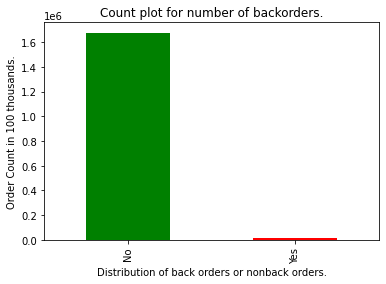

In [6]:
fig = df['went_on_backorder'].value_counts().plot.bar(color=['green','red'])
fig.set_title('Count plot for number of backorders.')
fig.set_xlabel('Distribution of back orders or nonback orders.')
fig.set_ylabel('Order Count in 100 thousands.')
plt.show()

### Following can be inferred:
    1. There is a huge imbalance in Backorders and NonBackorders.
    2. Positive class (Backorder) is extreme minority.

#### 1.2 Check impact of  non-availability of products .

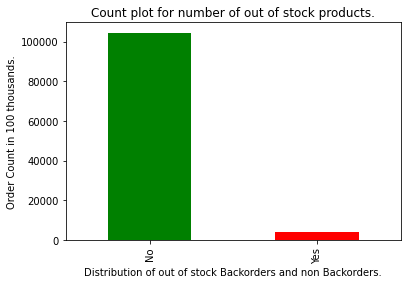

In [7]:
fig = df[df['national_inv']==0]['went_on_backorder'].value_counts().plot.bar(color=['green','red'])
fig.set_title('Count plot for number of out of stock products.')
fig.set_xlabel('Distribution of out of stock Backorders and non Backorders.')
fig.set_ylabel('Order Count in 100 thousands.')
plt.show()

In [8]:
df[df['national_inv']==0]['went_on_backorder'].value_counts()

No     104472
Yes      3953
Name: went_on_backorder, dtype: int64

### Following can be inferred:
    1.A huge number of products which are out of stock are Non Backorder products.
    2.But there is considerable amount(4K) of Backorder products out of stock as well.

#### 1.3 Impact of Transit Time on target variable

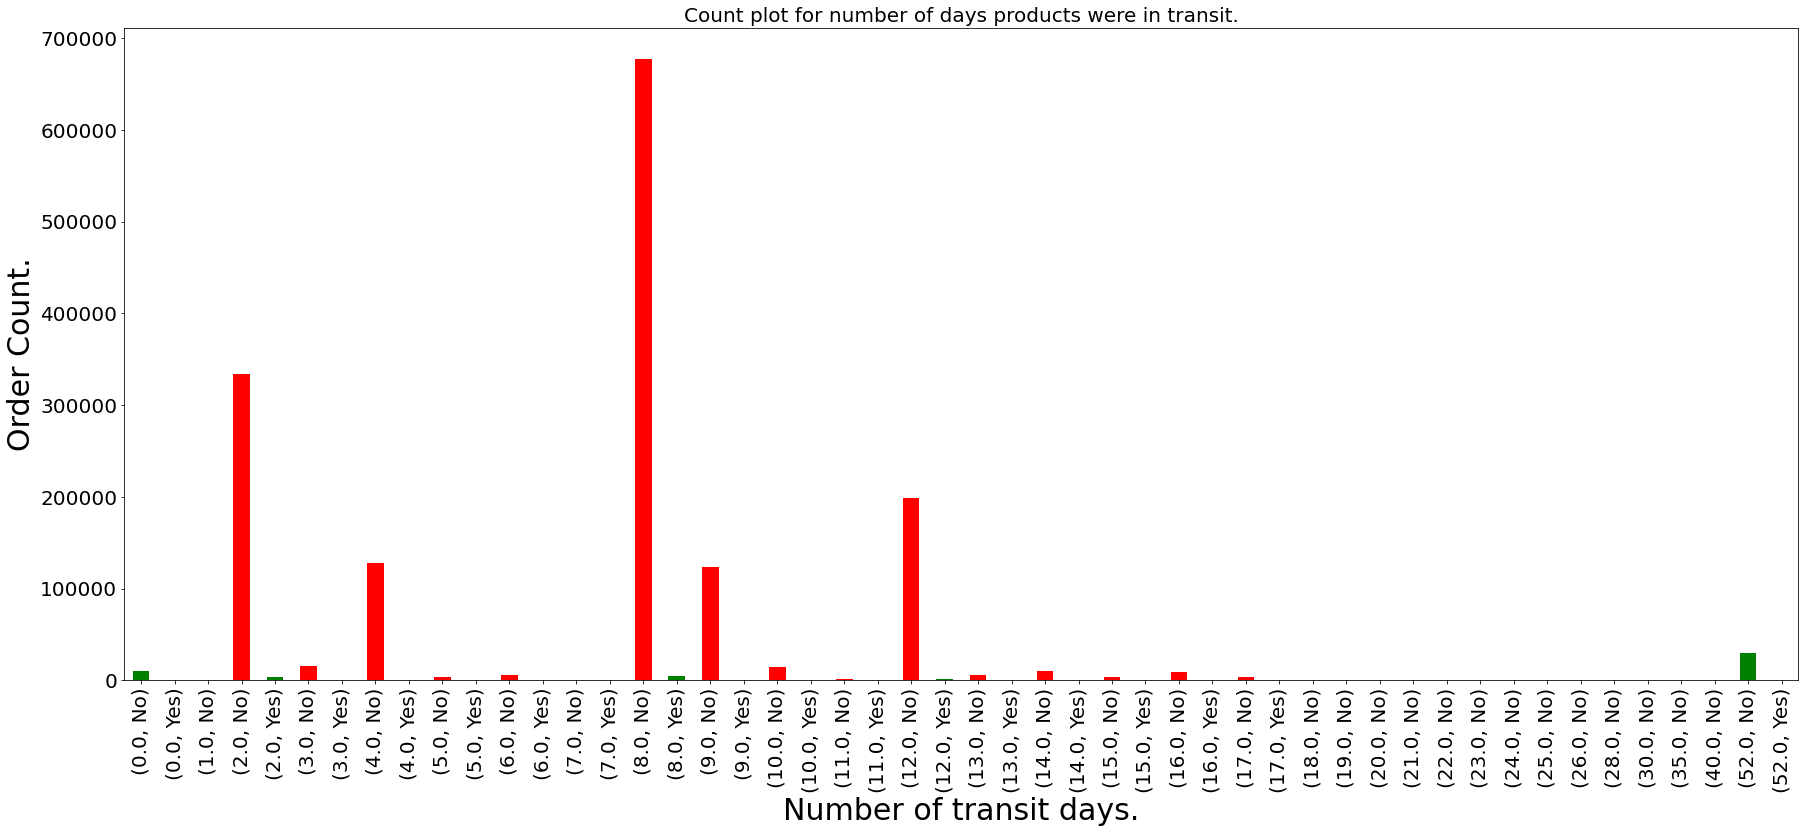

In [9]:
plt.figure(figsize=(30,12))
ax = df[['lead_time','went_on_backorder']].value_counts(sort=False).plot.bar(color=['green','red'])
ax.set_title('Count plot for number of days products were in transit.',fontsize=20)
ax.set_xlabel('Number of transit days.',fontsize=30)
ax.set_ylabel('Order Count.',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

#### Following can be inferred:
    1. 8 days are taken for 700K  products non backorder.
    2. Fastest transit took place within a day for non backorder.
    3. Slowest transit for approx 20k products took 52 days for non backorders that is acceptable.
    
##### It evident that a transit time from 2 days to 12 days is acceptable for backorders.

#### 1.4 Impact of transit quantity on target variable

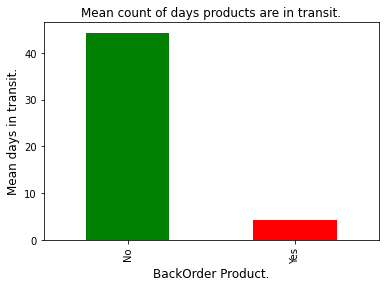

In [10]:
tmp = df[['in_transit_qty','went_on_backorder']]
tmp = tmp.groupby('went_on_backorder')['in_transit_qty'].mean()
fig = tmp.plot.bar(color=['green','red'])
fig.set_title('Mean count of days products are in transit.',fontsize=12)
fig.set_xlabel('BackOrder Product.',fontsize=12)
fig.set_ylabel('Mean days in transit.',fontsize=12)
plt.show()

In [72]:
print(tmp)

went_on_backorder
No     44.319523
Yes     4.338617
Name: in_transit_qty, dtype: float64


#### Following can be inferred: 
    1. On an avg 4 backorder products are in transit.
    2. On an avg 45 Non Backorder products are in transit but this can be attributed to high quantity.

#### 1.5 Impact of  sales(1,3 ,6 ,9) month on target variable

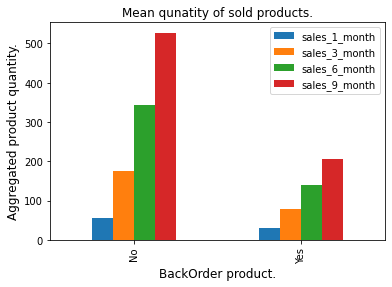

In [11]:
sales_tmp = df[['sales_1_month','sales_3_month','sales_6_month','sales_9_month','went_on_backorder']]
sales_tmp_series = sales_tmp.groupby('went_on_backorder')[['sales_1_month','sales_3_month',\
                                                           'sales_6_month','sales_9_month']].mean()

fig = sales_tmp_series.plot.bar()
fig.set_title('Mean qunatity of sold products.',fontsize=12)
fig.set_xlabel('BackOrder product.',fontsize=12)
fig.set_ylabel('Aggregated product quantity.',fontsize=12)
plt.show()

#### Sale of Backorder products are less than Non backorder products.

#### 1.6 Impact of  forecast sales(3 ,6, 9) month on target variable

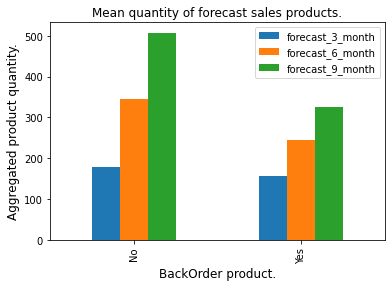

In [12]:
forecast_sales_tmp = df[['forecast_3_month','forecast_6_month','forecast_9_month','went_on_backorder']]
forecast_sales_tmp_series = forecast_sales_tmp.groupby('went_on_backorder')[['forecast_3_month',\
                                                                   'forecast_6_month',\
                                                                   'forecast_9_month']].mean()


fig = forecast_sales_tmp_series.plot.bar()
fig.set_title('Mean quantity of forecast sales products.',fontsize=12)
fig.set_xlabel('BackOrder product.',fontsize=12)
fig.set_ylabel('Aggregated product quantity.',fontsize=12)
plt.show()

#### 1.7 Impact of potential issue variable

In [13]:
print(df[['potential_issue','went_on_backorder']].value_counts())

potential_issue  went_on_backorder
No               No                   1675711
                 Yes                    11242
Yes              No                       856
                 Yes                       51
dtype: int64


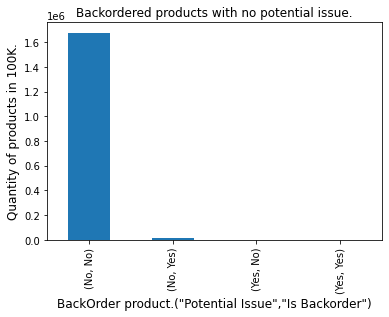

In [14]:
fig = df[['potential_issue','went_on_backorder']].value_counts().plot.bar()
fig.set_title('Backordered products with no potential issue.',fontsize=12)
fig.set_xlabel('BackOrder product.("Potential Issue","Is Backorder")',fontsize=12)
fig.set_ylabel('Quantity of products in 100K.',fontsize=12)
plt.show()

#### Following can be inferred:
     1.There are 51 Backorder products with potential issues,sp organization should identify the issue and create a better product with no such problems.
     2.In total there are almost 12k products with identified potential issues.

#### 1.8 Impact of min_bank feature

In [15]:
min_bank_df = df.groupby('went_on_backorder')['min_bank'].mean()

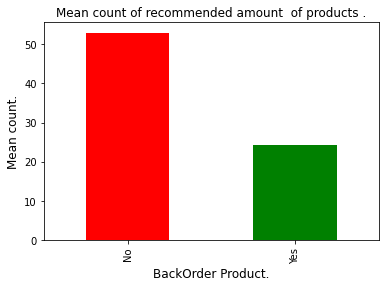

In [16]:
ax = min_bank_df.plot.bar(color=['red','green'])
ax.set_title('Mean count of recommended amount  of products .',fontsize=12)
ax.set_xlabel('BackOrder Product.',fontsize=12)
ax.set_ylabel('Mean count.',fontsize=12)
plt.show()

#### Following can be inferred:
    1.Backorder products are recommended to be 25 in quantity(aggregate).
    2.Non backorder products are double in recommendation.

#### 1.9 Impact of pieces_due from source on backorder

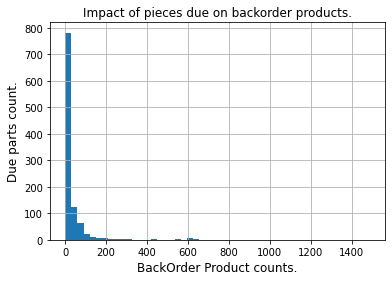

In [17]:
pieces_due = df[(df['went_on_backorder']=='Yes') & (df['pieces_past_due']!=0)]['pieces_past_due']
ax = pieces_due.hist(bins=50)
ax.set_title('Impact of pieces due on backorder products.',fontsize=12)
ax.set_xlabel('BackOrder Product counts.',fontsize=12)
ax.set_ylabel('Due parts count.',fontsize=12)
plt.show()

In [18]:
df[df['pieces_past_due']!=0].groupby('went_on_backorder')['pieces_past_due'].mean()

went_on_backorder
No     140.645960
Yes     38.087954
Name: pieces_past_due, dtype: float64

#### Following can be inferred:
    1. There is a group of 30-40 products with almost 800 parts due collectively, this is critical issue and should be  addressed as early as possible.
    2. On an average 38 parts are overdue for backorder products.
    3. On an avrage 140 parts are overdue for non backordr products.
    

#### 1.10 Impact of past performance of products

In [19]:
df['perf_6_month_avg'].describe()

count    1.687860e+06
mean    -6.872059e+00
std      2.655636e+01
min     -9.900000e+01
25%      6.300000e-01
50%      8.200000e-01
75%      9.700000e-01
max      1.000000e+00
Name: perf_6_month_avg, dtype: float64

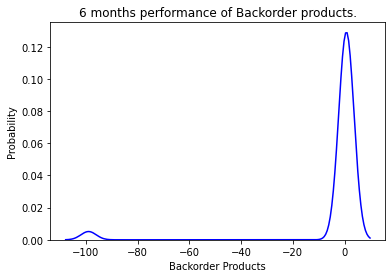

In [20]:
sns.kdeplot(df[df['went_on_backorder']=='Yes']['perf_6_month_avg'], color='b')
  
# Setting the X and Y Label
plt.title('6 months performance of Backorder products.')
plt.xlabel('Backorder Products')
plt.ylabel('Probability')
plt.show()

In [21]:
df['perf_12_month_avg'].describe()

count    1.687860e+06
mean    -6.437947e+00
std      2.584333e+01
min     -9.900000e+01
25%      6.600000e-01
50%      8.100000e-01
75%      9.500000e-01
max      1.000000e+00
Name: perf_12_month_avg, dtype: float64

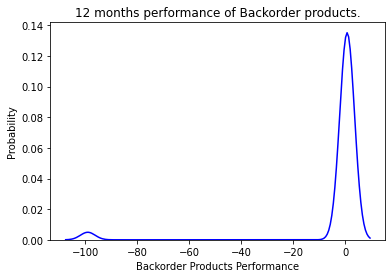

In [22]:
sns.kdeplot(df[df['went_on_backorder']=='Yes']['perf_12_month_avg'], color='b')
# Setting the X and Y Label
plt.title('12 months performance of Backorder products.')
plt.xlabel('Backorder Products Performance')
plt.ylabel('Probability')
plt.show()

#### Prior 6 and 12 months performance is same for both 6 months and 12 months duration.

In [62]:
#https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot
def plot_flags_features(df,feature):
    x, y, hue = feature, "proportion", "went_on_backorder"
    hue_order = ["Yes", "No"]
    print(df[x].groupby(df[hue]).value_counts())
    (df[x]
     .groupby(df[hue])
     .value_counts(normalize=True)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

    plt.show()

went_on_backorder  rev_stop
No                 No          1675836
                   Yes             731
Yes                No            11293
Name: rev_stop, dtype: int64


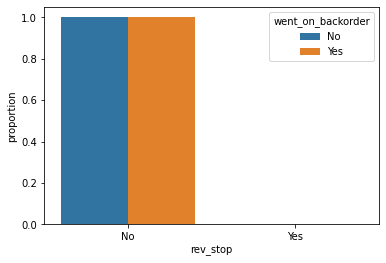

In [63]:
plot_flags_features(df,'rev_stop')

#### None of the item went to Backorder if rev_stop is set to Yes

went_on_backorder  deck_risk
No                 No           1291000
                   Yes           385567
Yes                No              9377
                   Yes             1916
Name: deck_risk, dtype: int64


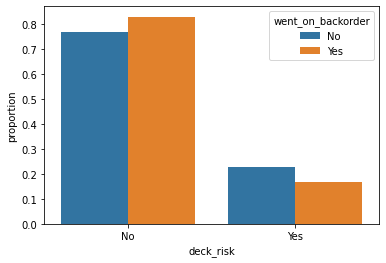

In [64]:
plot_flags_features(df,'deck_risk')

went_on_backorder  oe_constraint
No                 No               1676330
                   Yes                  237
Yes                No                 11285
                   Yes                    8
Name: oe_constraint, dtype: int64


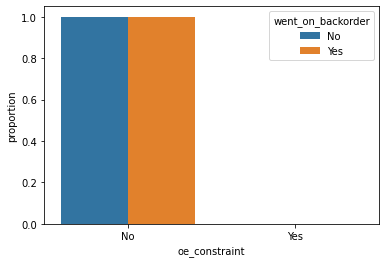

In [65]:
plot_flags_features(df,'oe_constraint')

went_on_backorder  ppap_risk
No                 No           1474492
                   Yes           202075
Yes                No              9534
                   Yes             1759
Name: ppap_risk, dtype: int64


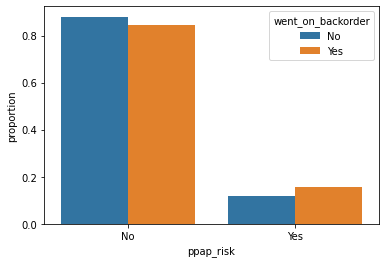

In [66]:
plot_flags_features(df,'ppap_risk')

##### ppap_risk feature is almost equally distributed

went_on_backorder  stop_auto_buy
No                 Yes              1615952
                   No                 60615
Yes                Yes                10822
                   No                   471
Name: stop_auto_buy, dtype: int64


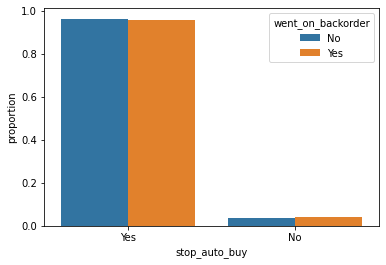

In [67]:
plot_flags_features(df,'stop_auto_buy')

####  stop_auto_buy risk flag is set to Yes there is almost equal proportion of both classes

## Bivariate Analysis

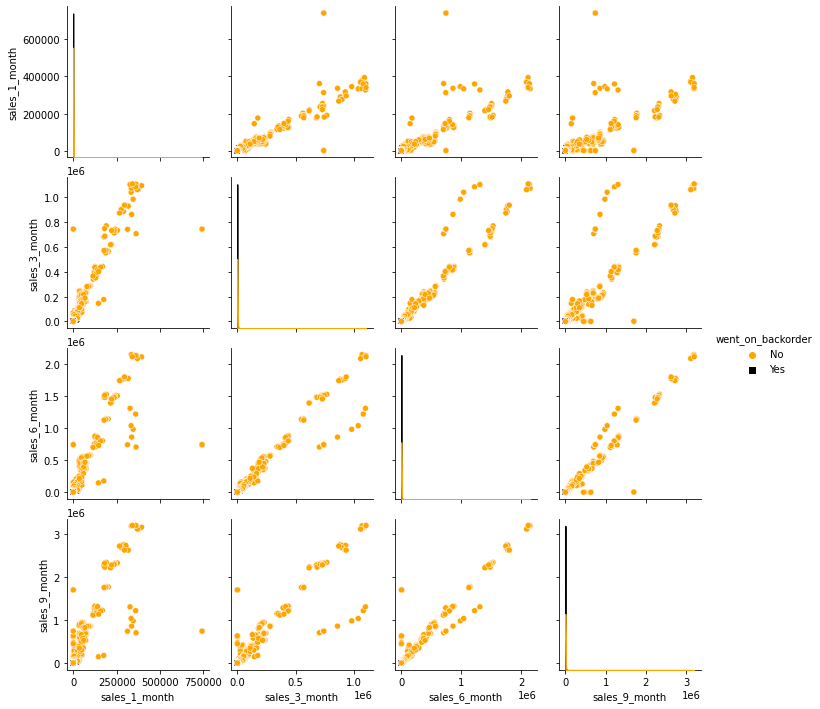

In [23]:
df_pair = df[['sales_1_month','sales_3_month','sales_6_month',
              'sales_9_month','went_on_backorder']]

sns.pairplot(data=df_pair,hue='went_on_backorder',markers=["o", "s"],palette = {'Yes':'black',"No":'orange'})
plt.show()

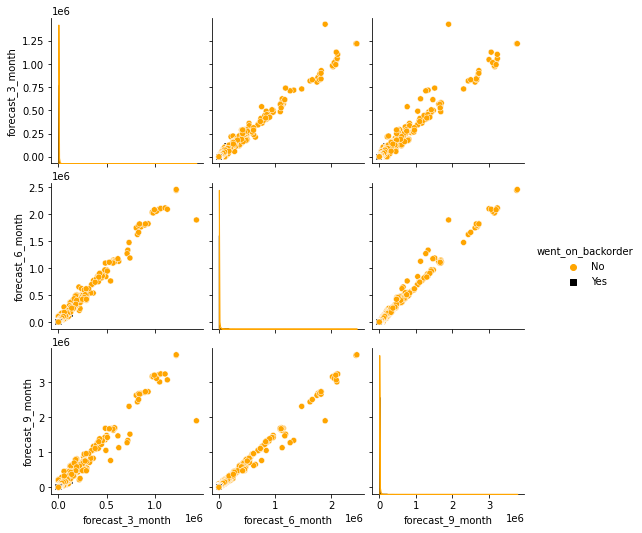

In [24]:
df_pair = df[['forecast_3_month','went_on_backorder',
              'forecast_6_month','forecast_9_month']]

sns.pairplot(data=df_pair,hue='went_on_backorder',markers=["o", "s"],palette = {'Yes':'black',"No":'orange'})
plt.show()

##### Correlation between Independent Categorical features and Target Variable(Categorical)
<br><center><b><em>Chi-square Test</em></b></center><br>
\begin{equation*}
 \mathbf{X^2} = \frac{\sum_{i=1}^n (Observed_i - Expected_i)^2}{\sum_{j=1}^n (Expected_j)}
\end{equation*}

#### NULL Hypothesis : Independent variables are not correlated with Dependent Variable 

In [25]:
## https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365
## https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
## https://en.wikipedia.org/wiki/Contingency_table
# We can make contigency table out of these variables using pandas crosstab() function
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
Table = PrettyTable(["Feature Name","Feature is Dependent", "p_value", "Null Hypothesis Status"])

cat_cols = ['potential_issue','deck_risk','oe_constraint','ppap_risk',
            'stop_auto_buy','rev_stop','went_on_backorder']

target_col = 'went_on_backorder'

alpha = 0.05

for col in cat_cols:
    table_col = pd.crosstab(df[target_col], df[col])
    stat, p, dof, expected = chi2_contingency(table_col)
    
    if p <= alpha:
        Table.add_row([col,True,p,"Rejected"])
    
print(Table)

+-------------------+----------------------+------------------------+------------------------+
|    Feature Name   | Feature is Dependent |        p_value         | Null Hypothesis Status |
+-------------------+----------------------+------------------------+------------------------+
|  potential_issue  |         True         | 3.0754846573427014e-73 |        Rejected        |
|     deck_risk     |         True         | 4.981380770364453e-52  |        Rejected        |
|   oe_constraint   |         True         | 4.362933706176436e-06  |        Rejected        |
|     ppap_risk     |         True         | 2.7404638447902615e-30 |        Rejected        |
|   stop_auto_buy   |         True         | 0.0017855596321260765  |        Rejected        |
|      rev_stop     |         True         |  0.04630940389527151   |        Rejected        |
| went_on_backorder |         True         |          0.0           |        Rejected        |
+-------------------+----------------------+------

#### Using Point-Biseral Correlation for Dependent Categorical Feature and Continuous Independent Feature

In [6]:
target_col = 'went_on_backorder'
df[target_col].replace({"Yes":1,"No":0},inplace=True)

In [7]:
## Drop the last row as it is all Nan
df = df.iloc[:1687860]
df[target_col] = df[target_col].astype(float)

In [8]:
# Not including lead_time feature because of Missing values
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html


cols = ['national_inv','in_transit_qty','forecast_3_month','forecast_6_month',\
       'forecast_9_month','sales_1_month','sales_3_month','sales_6_month',\
       'sales_9_month','min_bank','pieces_past_due',\
       'perf_6_month_avg','perf_12_month_avg','local_bo_qty']


Table = PrettyTable(["Feature Name","Feature is Correlated","r_value", "Null Hypothesis Status"])


alpha = 0.05
for col in cols:
    
    r_value, p_value = pointbiserialr(df[target_col].values.ravel(),df[col])
    
    if p_value <= alpha:
        Table.add_row([col,True,r_value,"Rejected"])
    else:
        Table.add_row([col,False,r_value,"Fail to Reject Hypothesis"])
    
print(Table)


+-------------------+-----------------------+-------------------------+---------------------------+
|    Feature Name   | Feature is Correlated |         r_value         |   Null Hypothesis Status  |
+-------------------+-----------------------+-------------------------+---------------------------+
|    national_inv   |         False         |  -0.0013154647696244403 | Fail to Reject Hypothesis |
|   in_transit_qty  |          True         |  -0.002427386749404033  |          Rejected         |
|  forecast_3_month |         False         | -0.00033969590440422983 | Fail to Reject Hypothesis |
|  forecast_6_month |         False         |  -0.0008404611441742226 | Fail to Reject Hypothesis |
|  forecast_9_month |         False         |  -0.0010298274405346395 | Fail to Reject Hypothesis |
|   sales_1_month   |         False         |  -0.0011305696825252925 | Fail to Reject Hypothesis |
|   sales_3_month   |          True         |  -0.0015122631307842277 |          Rejected         |


## 2. Data Preprocessing

#### 2.1 Multiple object type categorical features are present with 'Yes' , 'No' values convert these two numerical 1, 0 respectively

In [9]:
cols = ['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop']

for col in cols:
    df[col].replace(to_replace=['Yes','No'],value=[1.0,0.0],inplace=True)

In [10]:
#Convert sku feature to number 
def find_number(text):
    num = re.findall(r'[0-9]+',str(text))
    return " ".join(num)

df['sku']=df['sku'].apply(lambda x: find_number(x))

#### 2.2 Check the data types of all freatures

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687860 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  float64
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

#### 2.3 Make sku code as index because it is an unique identifier for the product


In [12]:
df.set_index('sku',inplace=True) 

#### Highly imbalanced binary dataset

In [13]:
df['went_on_backorder'].value_counts()

0.0    1676567
1.0      11293
Name: went_on_backorder, dtype: int64

#### Imbalance in the ratio of 148:1

#### lead_time feature is missing 100894 values roughly , it is an important feature .

In [36]:
df[df['lead_time'].isna() == True]

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.0,-99.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.0,-99.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,-99.0,-99.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1044643,1095.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.0,-99.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1045815,140.0,NaN,0.0,15.0,114.0,152.0,0.0,0.0,0.0,0.0,...,0.0,-99.0,-99.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406654,42.0,NaN,0.0,0.0,0.0,0.0,33.0,99.0,186.0,299.0,...,0.0,-99.0,-99.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1588495,227.0,NaN,8.0,0.0,0.0,0.0,19.0,78.0,205.0,289.0,...,0.0,-99.0,-99.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1375861,-206.0,NaN,0.0,760.0,1145.0,1453.0,114.0,853.0,1764.0,2706.0,...,0.0,-99.0,-99.0,206.0,1.0,0.0,0.0,1.0,0.0,0.0


In [57]:
df[df['lead_time'].isna() == False].index

Index(['1043384', '1043852', '1044198', '1045098', '1045867', '1045918',
       '1049468', '1050390', '1050440', '1050856',
       ...
       '1573563', '1460296', '1373539', '1478683', '1489920', '1392420',
       '1407754', '1524346', '1439563', '1502009'],
      dtype='object', name='sku', length=1586967)

In [62]:
df.loc[['1043384', '1043852', '1044198', '1045098', '1045867', '1045918',
       '1049468', '1050390', '1050440', '1050856','1573563', '1460296', '1373539', '1478683', '1489920', '1392420',
       '1407754', '1524346', '1439563', '1502009']]

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1044198,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.87,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1045098,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1045867,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.87,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1045918,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.91,0.82,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1049468,11.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.78,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1050390,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.00,0.98,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1050440,169.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.00,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [80]:
dfff = df.loc[['1489920','1524346','1043384', '1043852', '1044198', '1045098', '1045867', '1045918',
       '1049468', '1050390', '1050440', '1050856','1573563', '1460296', '1373539', '1478683', '1489920', '1392420',
       '1407754', '1524346', '1439563', '1502009']]
dfff[['lead_time', 'in_transit_qty', 'min_bank', 'potential_issue',
       'perf_6_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy','went_on_backorder']]

,lead_time,in_transit_qty,min_bank,potential_issue,perf_6_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,went_on_backorder
sku,,,,,,,,,,,
1489920,2.0,0.0,657.0,0.0,0.98,4.0,0.0,0.0,0.0,0.0,1.0
1524346,9.0,0.0,0.0,0.0,0.86,1.0,1.0,0.0,0.0,0.0,1.0
1043384,9.0,0.0,0.0,0.0,0.99,0.0,0.0,0.0,0.0,1.0,0.0
1043852,8.0,0.0,1.0,0.0,0.10,0.0,0.0,0.0,0.0,1.0,0.0
1044198,8.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0,1.0,0.0
1045098,2.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,1.0,1.0,0.0
1045867,8.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0,1.0,0.0
1045918,2.0,0.0,0.0,0.0,0.91,0.0,0.0,0.0,0.0,1.0,0.0
1049468,8.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0,1.0,0.0


In [77]:
dfff.loc['1489920']

national_inv            0.00
lead_time               2.00
in_transit_qty          0.00
forecast_3_month     2071.00
forecast_6_month     3025.00
forecast_9_month     3412.00
sales_1_month           4.00
sales_3_month         764.00
sales_6_month         764.00
sales_9_month         765.00
min_bank              657.00
potential_issue         0.00
pieces_past_due         0.00
perf_6_month_avg        0.98
perf_12_month_avg       0.99
local_bo_qty            4.00
deck_risk               0.00
oe_constraint           0.00
ppap_risk               0.00
stop_auto_buy           0.00
rev_stop                0.00
went_on_backorder       1.00
Name: 1489920, dtype: float64

#### 2.4 Visualize Missing Values

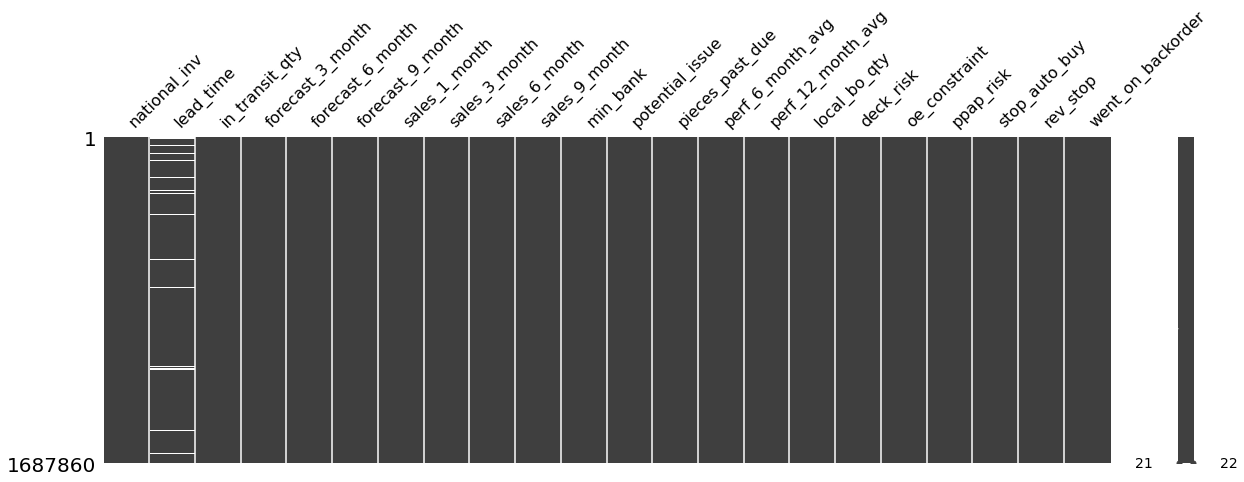

In [37]:
#To visualize what all values are missing we can use a library missingno 
#https://github.com/ResidentMario/missingno
obj_1 = mno.matrix(df, figsize = (20, 6))
obj_1.get_figure().savefig('missingValues.png', bbox_inches='tight')

#### Here we can see only missing value lies in lead_time feature.

### 2.5 Imputation based on Linear Regression for lead_time

In [24]:
missing_col = 'lead_time'
pred_cols = list(set(df.columns) - set(missing_col))

X = df[pred_cols].loc[df[missing_col].isnull()==False] 
y = df[missing_col].loc[df[missing_col].isnull()==False]
X.drop('lead_time',axis=1,inplace=True)

X_test = df[pred_cols].loc[df[missing_col].isnull()==True]
X_test.drop('lead_time',axis=1,inplace=True)

In [25]:
X.describe()

,forecast_6_month,sales_3_month,deck_risk,forecast_3_month,national_inv,pieces_past_due,min_bank,forecast_9_month,went_on_backorder,stop_auto_buy,...,in_transit_qty,perf_6_month_avg,potential_issue,sales_6_month,oe_constraint,ppap_risk,sales_9_month,perf_12_month_avg,local_bo_qty,rev_stop
count,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,...,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06
mean,3.653390e+02,1.784835e+02,2.032538e-01,1.887439e+02,4.895098e+02,2.172666e+00,5.320380e+01,5.362801e+02,6.911927e-03,9.753675e-01,...,4.547493e+01,-1.014934e+00,5.683798e-04,3.522319e+02,1.543825e-04,1.188090e-01,5.441272e+02,-5.532225e-01,6.333207e-01,2.583545e-04
std,1.009962e+04,4.971129e+03,4.024199e-01,5.182992e+03,3.046168e+04,2.434021e+02,1.119034e+03,1.482576e+04,8.285021e-02,1.550025e-01,...,1.309357e+03,1.327273e+01,2.383395e-02,9.679297e+03,1.242412e-02,3.235638e-01,1.514871e+04,1.144580e+01,3.343933e+01,1.607134e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,6.900000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.900000e-01,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,8.400000e-01,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,8.200000e-01,0.000000e+00,0.000000e+00
75%,1.500000e+01,1.600000e+01,0.000000e+00,5.000000e+00,7.800000e+01,0.000000e+00,3.000000e+00,2.500000e+01,0.000000e+00,1.000000e+00,...,0.000000e+00,9.700000e-01,0.000000e+00,3.300000e+01,0.000000e+00,0.000000e+00,5.000000e+01,9.600000e-01,0.000000e+00,0.000000e+00
max,2.461360e+06,1.105478e+06,1.000000e+00,1.427612e+06,1.233440e+07,1.464960e+05,2.057860e+05,3.777304e+06,1.000000e+00,1.000000e+00,...,4.894080e+05,1.000000e+00,1.000000e+00,2.146625e+06,1.000000e+00,1.000000e+00,3.205172e+06,1.000000e+00,1.253000e+04,1.000000e+00


In [26]:
X_test.describe()

,forecast_6_month,sales_3_month,deck_risk,forecast_3_month,national_inv,pieces_past_due,min_bank,forecast_9_month,went_on_backorder,stop_auto_buy,...,in_transit_qty,perf_6_month_avg,potential_issue,sales_6_month,oe_constraint,ppap_risk,sales_9_month,perf_12_month_avg,local_bo_qty,rev_stop
count,100893.000000,1.008930e+05,100893.000000,100893.000000,100893.000000,100893.000000,100893.000000,100893.000000,100893.000000,100893.000000,...,100893.000000,100893.0,100893.00000,1.008930e+05,100893.0,100893.000000,1.008930e+05,100893.0,100893.000000,100893.000000
mean,24.860258,1.206405e+02,0.643513,11.002894,599.955507,0.015561,45.985202,35.814338,0.003211,0.781997,...,21.670879,-99.0,0.00005,1.765246e+02,0.0,0.151527,2.286565e+02,-99.0,0.518391,0.003182
std,747.502334,7.894806e+03,0.478964,338.081913,8785.828101,2.433645,2579.056152,1120.038314,0.056578,0.412892,...,1787.484665,0.0,0.00704,8.503946e+03,0.0,0.358563,8.592103e+03,0.0,37.895397,0.056316
min,0.000000,0.000000e+00,0.000000,0.000000,-4573.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-99.0,0.00000,0.000000e+00,0.0,0.000000,0.000000e+00,-99.0,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,-99.0,0.00000,0.000000e+00,0.0,0.000000,0.000000e+00,-99.0,0.000000,0.000000
50%,0.000000,0.000000e+00,1.000000,0.000000,22.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,-99.0,0.00000,1.000000e+00,0.0,0.000000,1.000000e+00,-99.0,0.000000,0.000000
75%,0.000000,4.000000e+00,1.000000,0.000000,113.000000,0.000000,2.000000,0.000000,0.000000,1.000000,...,0.000000,-99.0,0.00000,8.000000e+00,0.0,0.000000,1.300000e+01,-99.0,0.000000,0.000000
max,74986.000000,1.100523e+06,1.000000,35792.000000,917218.000000,573.000000,313319.000000,112141.000000,1.000000,1.000000,...,285365.000000,-99.0,1.00000,1.309162e+06,0.0,1.000000,1.309162e+06,-99.0,7048.000000,1.000000


#### Preprocessing steps for regression
<b>1.</b> Standardize the continuous predictors<br>
<b>2.</b> Remove skewness of the data using box-cox transform


In [18]:
X.columns

Index(['forecast_6_month', 'sales_3_month', 'deck_risk', 'forecast_3_month',
       'national_inv', 'pieces_past_due', 'min_bank', 'forecast_9_month',
       'went_on_backorder', 'stop_auto_buy', 'sales_1_month', 'in_transit_qty',
       'perf_6_month_avg', 'potential_issue', 'sales_6_month', 'oe_constraint',
       'ppap_risk', 'sales_9_month', 'perf_12_month_avg', 'local_bo_qty',
       'rev_stop'],
      dtype='object')

In [45]:
columns = ['in_transit_qty','min_bank','potential_issue',
           'perf_6_month_avg','local_bo_qty','deck_risk','oe_constraint','ppap_risk','stop_auto_buy']

final_data_df = X[columns]

In [46]:
#final_data_df.columns = columns
final_data_df.head()

,in_transit_qty,min_bank,potential_issue,perf_6_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy
sku,,,,,,,,,
1043384,0.0,0.0,0.0,0.99,0.0,0.0,0.0,0.0,1.0
1043852,0.0,1.0,0.0,0.10,0.0,0.0,0.0,0.0,1.0
1044198,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0,1.0
1045098,0.0,0.0,0.0,0.00,0.0,1.0,0.0,1.0,1.0
1045867,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0,1.0


In [47]:
final_data_df.insert(0, 'lead_time',y,allow_duplicates=True)
final_data_df.reset_index(drop=True,inplace=True)
final_data_df.head()

,lead_time,in_transit_qty,min_bank,potential_issue,perf_6_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy
0,9.0,0.0,0.0,0.0,0.99,0.0,0.0,0.0,0.0,1.0
1,8.0,0.0,1.0,0.0,0.10,0.0,0.0,0.0,0.0,1.0
2,8.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0,1.0
3,2.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,1.0,1.0
4,8.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0,1.0


In [48]:
final_data_df.to_csv('final_data.csv')

In [50]:
dff = pd.read_csv('final_data.csv')
dff.drop(['Unnamed: 0'],inplace=True,axis=1)
dff.head()

,lead_time,in_transit_qty,min_bank,potential_issue,perf_6_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy
0,9.0,0.0,0.0,0.0,0.99,0.0,0.0,0.0,0.0,1.0
1,8.0,0.0,1.0,0.0,0.10,0.0,0.0,0.0,0.0,1.0
2,8.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0,1.0
3,2.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,1.0,1.0
4,8.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0,1.0


In [65]:
columns = dff.columns
print(columns)

Index(['lead_time', 'in_transit_qty', 'min_bank', 'potential_issue',
       'perf_6_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy'],
      dtype='object')


In [52]:
from sklearn import preprocessing
cols =['in_transit_qty','min_bank','potential_issue',
      'perf_6_month_avg','local_bo_qty']
scaler = preprocessing.StandardScaler().fit(X[cols])
X[cols] = scaler.transform(X[cols])
X_test[cols] = scaler.transform(X_test[cols])

In [55]:
type(X_test.iloc[0])

pandas.core.series.Series

In [41]:
#Need to selectively normalize the data
from sklearn import preprocessing
cols = ['national_inv','in_transit_qty','forecast_3_month','forecast_6_month',\
       'forecast_9_month','sales_1_month','sales_3_month','sales_6_month',\
       'sales_9_month','min_bank','potential_issue','pieces_past_due',\
       'perf_6_month_avg','perf_12_month_avg','local_bo_qty']

scaler = preprocessing.StandardScaler().fit(X[cols])
X[cols] = scaler.transform(X[cols])
X_test[cols] = scaler.transform(X_test[cols])

In [42]:
#Skew on data
train_skew = X.skew()
test_skew = X_test.skew()
print('#'*20+"Train skew"+'#'*20)
print(train_skew)
print('#'*20+"Test skew"+'#'*20)
print(test_skew)

####################Train skew####################
in_transit_qty       169.959908
perf_6_month_avg      -7.244644
deck_risk              1.474811
stop_auto_buy         -6.133683
oe_constraint         80.463835
national_inv         332.475083
perf_12_month_avg     -8.481401
sales_9_month        133.628417
rev_stop              62.190504
forecast_6_month     134.820652
forecast_3_month     134.812516
local_bo_qty         168.181408
went_on_backorder     11.903138
ppap_risk              2.356206
sales_3_month        140.159832
min_bank             105.297169
forecast_9_month     139.031969
sales_1_month        207.146141
sales_6_month        139.773645
potential_issue       41.909316
pieces_past_due      399.881532
dtype: float64
####################Test skew####################
in_transit_qty       127.724035
perf_6_month_avg       0.000000
deck_risk             -0.599278
stop_auto_buy         -1.365987
oe_constraint          0.000000
national_inv          69.250352
perf_12_month_avg   

In [43]:
from scipy import stats

cols = ['national_inv','in_transit_qty','forecast_3_month','forecast_6_month',\
       'forecast_9_month','sales_1_month','sales_3_month','sales_6_month',\
       'sales_9_month','min_bank','potential_issue','pieces_past_due','local_bo_qty']

def log_transform(data,cols):
    for col in cols:
        series = np.log(data[col]+1)
        data[col] = pd.Series(series)

log_transform(X,cols)
print('#'*20+"Train skew after log transform"+'#'*20)
print(X[cols].skew())
print('#'*20+"Test skew after log transform"+'#'*20)
log_transform(X_test,cols)
print(X_test[cols].skew())

####################Train skew after log transform####################
national_inv        27.016101
in_transit_qty      15.945691
forecast_3_month    16.035910
forecast_6_month    16.264154
forecast_9_month    16.239437
sales_1_month       17.561662
sales_3_month       16.076463
sales_6_month       16.042405
sales_9_month       16.427719
min_bank            13.645989
potential_issue     41.909316
pieces_past_due     40.214984
local_bo_qty        28.529431
dtype: float64
####################Test skew after log transform####################
national_inv         17.735342
in_transit_qty       46.292030
forecast_3_month     37.587388
forecast_6_month     36.692898
forecast_9_month     38.231731
sales_1_month        37.241946
sales_3_month        32.117759
sales_6_month        28.807037
sales_9_month        26.412909
min_bank             21.273163
potential_issue     142.042951
pieces_past_due     191.670835
local_bo_qty         37.459082
dtype: float64


In [44]:
#Define Model
model = Ridge()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 50)
space['fit_intercept'] = [True, False]

# define search
search = RandomizedSearchCV(model, space, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -3.7894122267958408
Best Hyperparameters: {'alpha': 1.5256983105463716e-05, 'fit_intercept': True, 'solver': 'svd'}


In [45]:
params = result.best_params_
print(params)

{'alpha': 1.5256983105463716e-05, 'fit_intercept': True, 'solver': 'svd'}


#### Training the best model from the best parameters achieved after HyperParameterTuning to impute the lead_time feature.

In [46]:
best_model = Ridge(solver=params['solver'], alpha=params['alpha'],\
                   fit_intercept=params['fit_intercept'])
best_model.fit(X,y)
y_test  = best_model.predict(X_test)

In [47]:
df['lead_time'].loc[df['lead_time'].isnull()] = y_test

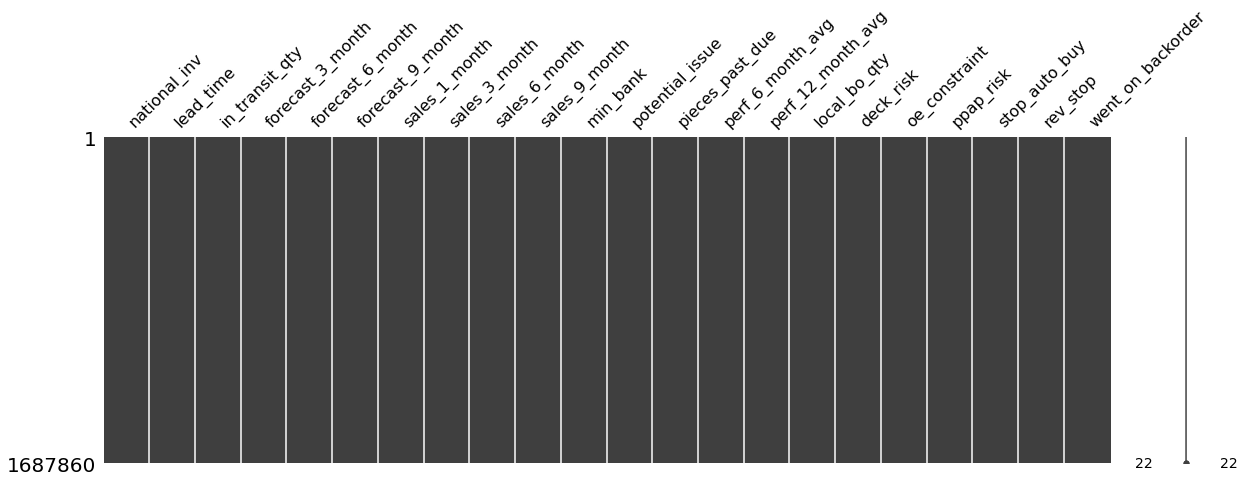

In [48]:
obj_2 = mno.matrix(df, figsize = (20, 6))
obj_2.get_figure().savefig('FilledValues.png', bbox_inches='tight')

#### A point to note is , we have used Linear Regresion to impute the value , so the values will be exact points on the regression line without any noise.
     The noise is expected in real world data can also add some Gaussian noise but I am considering it without noise.

In [49]:
df.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
1026827,0.0,12.145479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1043384,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1043696,2.0,13.823247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1043852,7.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1044048,8.0,13.825169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [50]:
df.reset_index(inplace=True)


In [51]:
#Use this file 
df.to_csv('final_imputed_data.csv')

In [52]:
del model
del X
del y
del missing_col
del pred_cols
del X_test
del obj_1
del obj_2
del df

In [53]:
gc.collect()

79069

In [3]:
df_imputed = pd.read_csv('final_imputed_data.csv',index_col='sku')

###  2.6 Feature Selection

In [4]:
df_imputed.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
# View the data snippet
df_imputed.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
sku,,,,,,,,,,,,,,,,,,,,,
1026827,0.0,12.145479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1043384,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1043696,2.0,13.823247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1043852,7.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1044048,8.0,13.825169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [6]:
# Shape of the data set
print(df_imputed.shape)

(1687860, 22)


In [7]:
# Descriptive Statistics of the dataset
df_imputed.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,...,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,8.358348e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,...,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01,2.295706e-01,1.451542e-04,1.207648e-01,9.638086e-01,4.330928e-04,6.690721e-03
std,2.961523e+04,7.219352e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,...,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01,4.205568e-01,1.204713e-02,3.258538e-01,1.867661e-01,2.080638e-02,8.152275e-02
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,...,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,...,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,...,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
# Class distribution
df_imputed['went_on_backorder'].value_counts()

0.0    1676567
1.0      11293
Name: went_on_backorder, dtype: int64

###  Multivariate Analysis

##### Correlation HeatMap

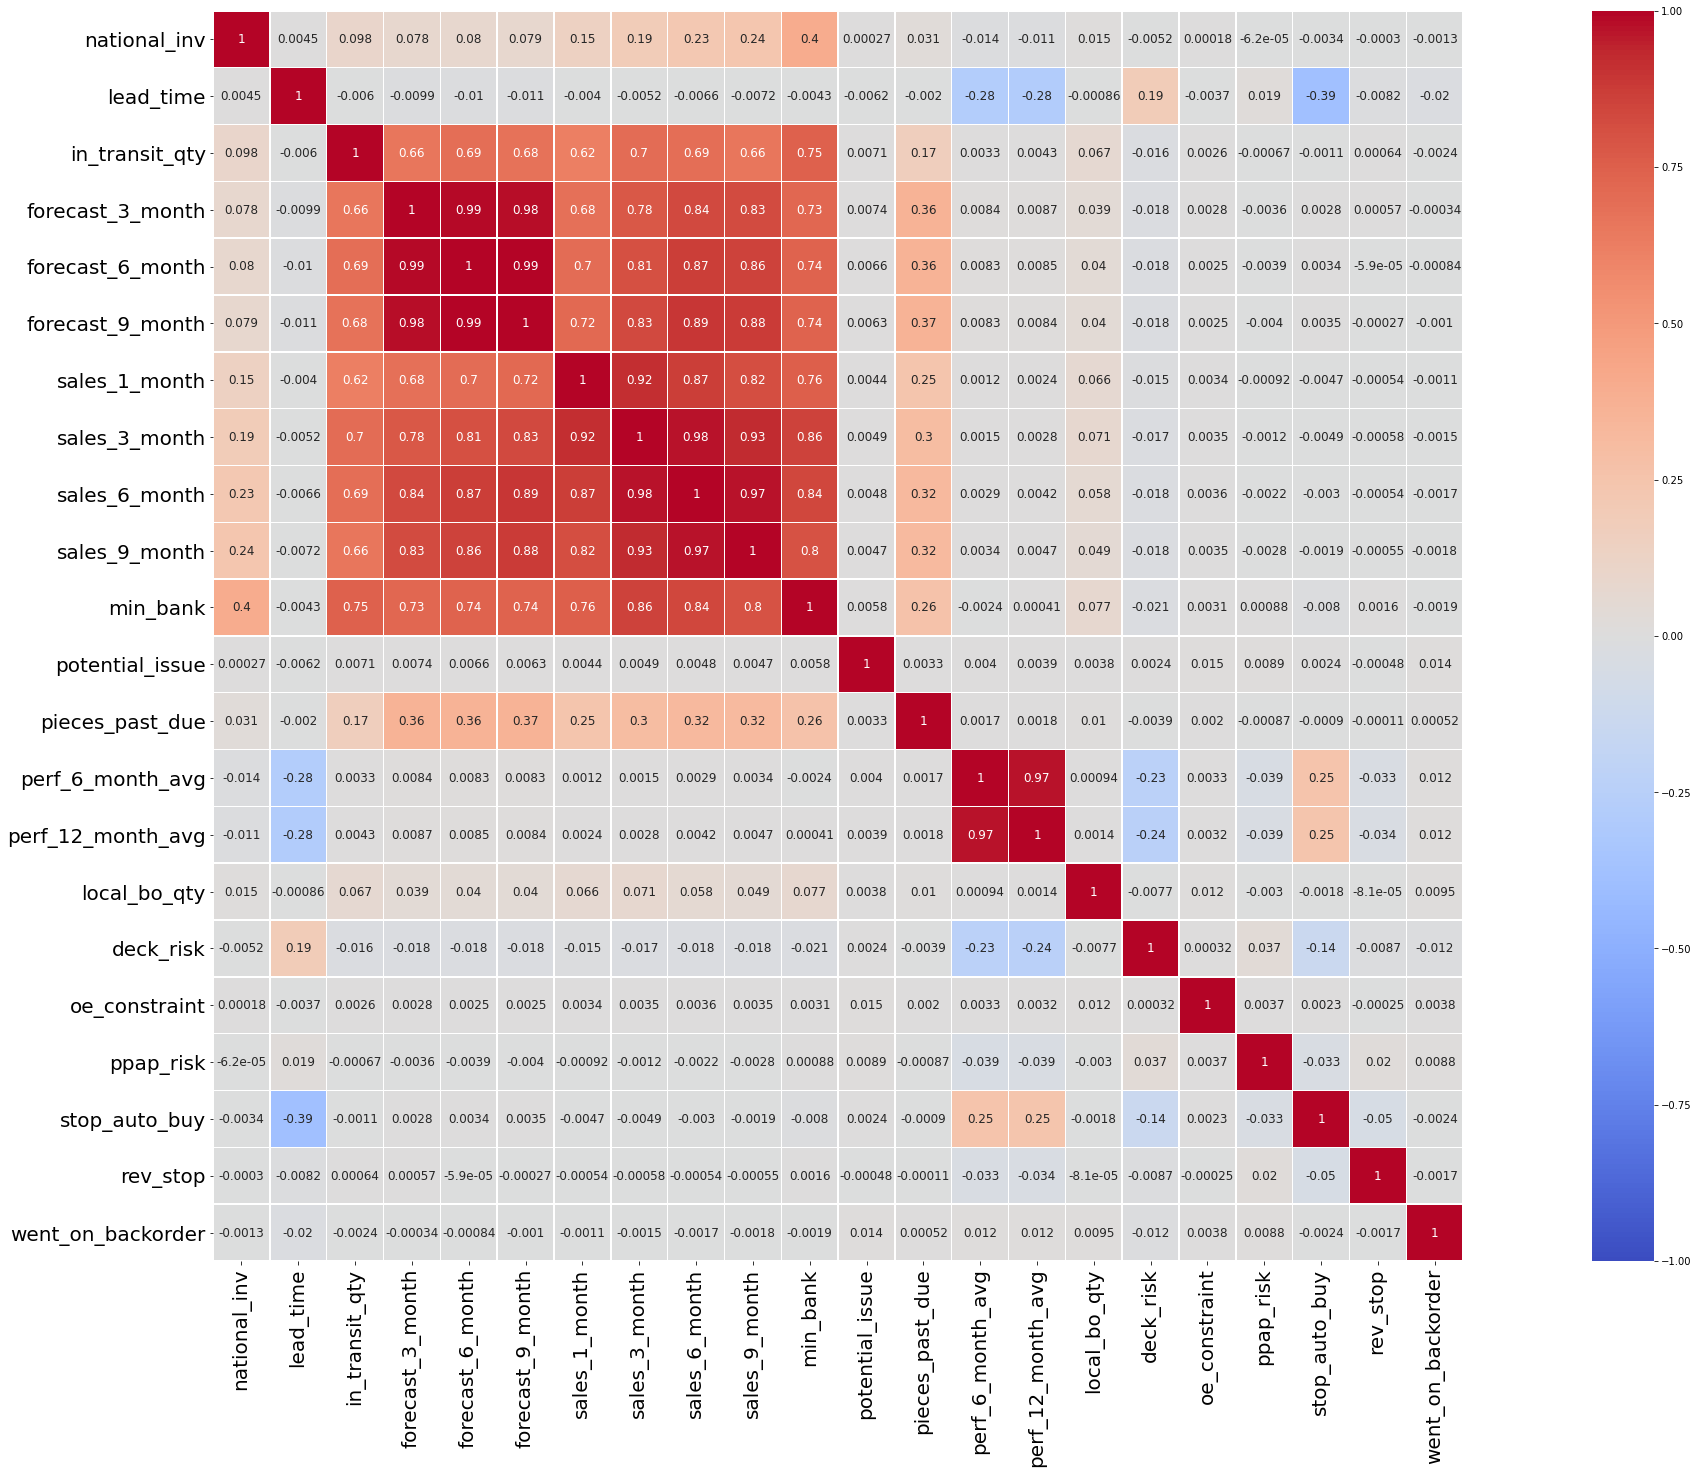

In [5]:
# Correlation between attributes

# Set a random seed 
rs = np.random.RandomState(33)

d = df_imputed

# Compute the correlation matrix
corr = d.corr()

# Generate a mask ,if want to show  upper triangle only
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(46, 23))


# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, cmap='coolwarm', vmax=1.0,vmin=-1.0,
                      center=0,square=True, linewidths=.5, cbar_kws={"shrink": 1.0},
                      annot = True,annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0,fontsize = 20)
ax.set_xticklabels(corr.columns,rotation=90,fontsize = 20)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

#save the heatmap
heatmap.get_figure().savefig('heatmap.png', bbox_inches='tight')

##### Not using Scatter plots because of number of features


<b>1.</b>Remove Collinear features using Pearson correlation with correlation value greater than 0.9.<br>
<b>2.</b>Select 10 best from these collinear features using SelectKBest with ANOVA (majoriy of predictrs are coninuous).

In [6]:
#remove one of the two column with higher corr with 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = df_imputed.columns[columns]
non_corr_df = df_imputed[selected_columns]

# print removed columns
removed_columns = df_imputed.columns[columns==False]
print(removed_columns)

Index(['forecast_6_month', 'forecast_9_month', 'sales_3_month',
       'sales_6_month', 'sales_9_month', 'perf_12_month_avg'],
      dtype='object')


In [7]:
#7 columns have been removed
non_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 1026827 to 1502009
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   national_inv       1687860 non-null  float64
 1   lead_time          1687860 non-null  float64
 2   in_transit_qty     1687860 non-null  float64
 3   forecast_3_month   1687860 non-null  float64
 4   sales_1_month      1687860 non-null  float64
 5   min_bank           1687860 non-null  float64
 6   potential_issue    1687860 non-null  float64
 7   pieces_past_due    1687860 non-null  float64
 8   perf_6_month_avg   1687860 non-null  float64
 9   local_bo_qty       1687860 non-null  float64
 10  deck_risk          1687860 non-null  float64
 11  oe_constraint      1687860 non-null  float64
 12  ppap_risk          1687860 non-null  float64
 13  stop_auto_buy      1687860 non-null  float64
 14  rev_stop           1687860 non-null  float64
 15  went_on_backorder  1687860

#### Use SelectKBest using Anova as statistic metric as one predictor are numerical and target categorical

In [8]:
#divede data into X and y from the uncorrelated data i.e dependent and independent feature
y_corr = non_corr_df['went_on_backorder']
X_corr = non_corr_df.drop('went_on_backorder',axis=1)

In [10]:
#Split Data into train and test data 
train_x,test_x, train_y, test_y = train_test_split(X_corr,y_corr,shuffle=True,test_size=0.25,stratify=y_corr)

In [11]:
#on all features on a quarter of data set
df_small  = df_imputed.sample(frac=0.25)
y_small = df_small['went_on_backorder']
X_small = df_small.drop(['went_on_backorder'],axis=1)
print(y_small.shape)
print(X_small.shape)

(421965,)
(421965, 21)


##### Univariate Analysis using SelectKBest

In [12]:
columns = train_x.columns
print(columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'sales_1_month', 'min_bank', 'potential_issue', 'pieces_past_due',
       'perf_6_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop'],
      dtype='object')


In [13]:
# configure to select 10 features
fs = SelectKBest(score_func=f_classif, k=10)
#mask = fs.get_support()

# learn relationship from training data
fit = fs.fit(train_x, train_y)

# transform train input data
X_train_fs = fs.transform(train_x)
# transform test input data
X_test_fs = fs.transform(test_x)

features = train_x.columns.values[fs.get_support()]
scores  = fs.scores_[fs.get_support()]

features_scores = list(zip(features, scores))
ns_df = pd.DataFrame(data = features_scores, columns=['Feature_names', 'Feature_Score'])
print(50*"#")
print(ns_df)

#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['Feature_Score', 'Feature_names'], ascending = [False, True])
print(50*"#")
print(ns_df_sorted)


##################################################
      Feature_names  Feature_Score
0         lead_time     479.135637
1    in_transit_qty       7.045102
2          min_bank       4.371310
3   potential_issue     216.955075
4  perf_6_month_avg     178.129482
5      local_bo_qty     162.843489
6         deck_risk     175.309736
7     oe_constraint      26.801169
8         ppap_risk      95.465088
9     stop_auto_buy       6.527835
##################################################
      Feature_names  Feature_Score
0         lead_time     479.135637
3   potential_issue     216.955075
4  perf_6_month_avg     178.129482
6         deck_risk     175.309736
5      local_bo_qty     162.843489
8         ppap_risk      95.465088
7     oe_constraint      26.801169
1    in_transit_qty       7.045102
9     stop_auto_buy       6.527835
2          min_bank       4.371310


In [28]:
train_x.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_1_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
sku,,,,,,,,,,,,,,,
2140667,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,0.0,0.0,1.0,0.0
2274561,24.0,8.0,2.0,12.0,4.0,0.0,0.0,0.0,0.95,0.0,0.0,0.0,0.0,1.0,0.0
1334358,22.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.42,0.0,0.0,0.0,0.0,1.0,0.0
1211442,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.91,0.0,1.0,0.0,0.0,1.0,0.0
3197865,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.90,0.0,1.0,0.0,0.0,1.0,0.0


In [14]:
print(X_train_fs.shape)
print(X_test_fs.shape)

(1265895, 10)
(421965, 10)


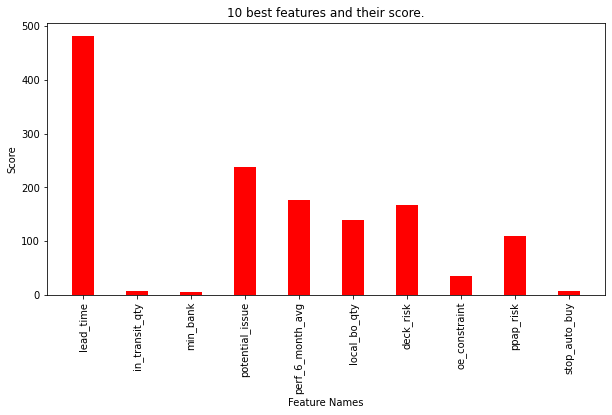

In [17]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(features, scores, color ='red',width = 0.4)
 
plt.xlabel("Feature Names")
plt.ylabel("Score")
plt.title("10 best features and their score.")
plt.xticks(rotation=90)
plt.show()

In [70]:
#del heatmap
#del df_scores
#del df_cols
gc.collect()

8740

## 2.7 Sampling

    1.SMOTE
    2.SMOTE with Undersampling


In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from collections import Counter


In [19]:
# transform the  train dataset only
# https://datascience.stackexchange.com/questions/15630/train-test-split-after-perform-smote

oversample = SMOTE()
X_1, y_1 = oversample.fit_resample(X_train_fs, train_y)
# summarize the new class distribution
counter = Counter(y_1)
print("Class ratio before:{}".format(Counter(train_y)))
print("Class ratio after SMOTE:{}".format(counter))

Class ratio before:Counter({0.0: 1257425, 1.0: 8470})
Class ratio after SMOTE:Counter({0.0: 1257425, 1.0: 1257425})


In [24]:
print(X_1.shape)
print(y_1.shape)

(2514850, 10)
(2514850,)


#### Storing the final processed data with top 10 features in seperate files.

In [37]:
final_train = pd.DataFrame(X_1,columns=features)

In [38]:
final_train['went_on_backorder'] = y_1

In [39]:
final_train.to_csv('final_train.csv')

In [40]:
final_test = pd.DataFrame(X_test_fs,columns=features)

In [41]:
final_test['went_on_backorder'] = test_y

In [42]:
final_test.to_csv('final_test.csv')

In [26]:
from numpy import save
save('X_1.npy',X_1)
save('y_1.npy',y_1)

In [27]:
save('X_1_test.npy',X_test_fs)
save('y_1_test.npy',test_y)

### Smote with Undersampling

In [74]:
# define pipeline
# oversample to 80% of the majority class
over = SMOTE()
#udersample majority class with 20% more data than minority class
under = RandomUnderSampler()

model = make_pipeline(over,under)
# transform the dataset
X_2, y_2 = model.fit_resample(X_train_fs, train_y)
# summarize the new class distribution
counter = Counter(y_2)
print(counter)

Counter({0.0: 1257425, 1.0: 1257425})


In [75]:
save('X_2.npy',X_2)
save('y_2.npy',y_2)

In [76]:
del X_1
del y_1
del X_2
del y_2
del oversample
del counter
del model
del under
del over
gc.collect()

48

### 3.Performance Metric

Imbalance in the dataset makes it clear that accuracy can not be used as a metric because of its ineffectiveness.
<ul>Candidates for metrics are
<li>F1-Score as both False Positive and False Negative cases will affect the business.</li>
<li>Macro F1-Score treats classes equally and give the same importance to each class. It will be low for models that only perform well on the common classes while performing poorly on the rare classes.</li>

</ul>